# Radon indexing of a demo dataset

In [1]:
# if installed from conda or pip, this is likely not necessary, but if installed from source, or using a developer branch, this can be quite useful. 
#import sys
#sys.path.insert(0, "/Path/to/PyEBSDIndex")

In [47]:
import matplotlib.pyplot as plt
import numpy as np
import h5py
import copy
from pyebsdindex import tripletvote, ebsd_pattern, ebsd_index, ebsdfile, pcopt
from pyebsdindex.EBSDImage import IPFcolor


### An example of indexing a file of patterns. 
Currently, the only types of files that can be indexed are the EDAX UP1/2 files, Oxford .ebsp uncompressed files, and HDF5 files.  There are built in tools to auto-recognize h5oim and Bruker HDF5 files.  Also see below on how to use h5py to input patterns from any (within some constraints) type of HDF5 file. 

First we define the environmental conditions of the data collection:

In [50]:
file = '/Path/to/example.up1' # or ebsp, or h5oina or Bruker h5
PC = np.array([0.46, 0.70, 0.64]) # this is pulled from the .ang file, but only is a rough guess.  We will refine in a bit. 
cam_elev = 5.3
sampleTilt = 70.0
vendor = 'EDAX'

Set up some phases.  There are some shortcuts for common phases (FCC, BCC, HCP). It should be noted that the setting up of the phase information also is initializing the method used for indexing the detected bands.  The default is to use triplet voting.  

For the first phase, we will use the shortcut method for FCC.  In its shortest form it will act as a generic FCC phase. This will automatically define the space group, set a lattice parameter = [1.0, 1.0, 1.0, 90, 90, 90], and define a set of reflecting pole families and set the phase name to "FCC".   

In [4]:
fcc = tripletvote.addphase(libtype = 'FCC' )

It is possible to override the defaults for any of the parameters and to set a phase name.  For example:

In [5]:
austenite = tripletvote.addphase(libtype = 'FCC', phasename = 'Austenite', latticeparameter=[0.355, 0.355, 0.355, 90, 90, 90])

If the phase is not one of the shortcut phases, then the space group, lattice parameters, and reflecting families need to be defined.  It should be noted that PyBSDIndex does no checks to make sure that the space group and lattice parameters have a matching specification.  Thus, if hexagonal lattice parameters are input to a cubic space group, it will produce nonsense results. Here, we will use a BCC lattice as an example: 

In [6]:
ferrite = tripletvote.addphase(phasename = 'Ferrite',
                              spacegroup = 229, 
                              latticeparameter=[0.286,0.286,0.286,90, 90, 90],
                              polefamilies =[[0, 1, 1], [0, 0, 2], [1, 1, 2], [0, 1, 3]])

Finally, we need to put these into a list.  As an implementation note, the default behavior is that if PyEBSDIndex matches at least seven bands to a phase, then the second phase is not even checked.  This is set as a reasonable trade-off for speed to accuracy, but can be changed if desired. Thus, putting the phase that is most likely to be found in the scan first does tend to index faster.  

In [7]:
phaselist = [austenite, ferrite]

For the truly lazy among us, there is also the option to define the shortcut phases as part of the list, which can be mixed and matched with the fully initiated phases above:

In [8]:
phaselistlazy = [austenite, 'BCC', 'HCP']

Define the radon and indexing parameters.  These work well for 60 x 60 patterns.  The most critical values are the size of `rSig` and `tSig`, which are fairly dependent on the band widths.  

In [9]:
nT = 180 # 180/nTheta == degree resolution 
nR = 90 
tSig = 2.0 # amount of gaussian kernel size in theta in units of radon pixels.
rSig = 2.0 # amount of gassian 2nd derivate in rho in units of radon pixels.
rhomask = 0.1 # fraction of radius to not analyze
backgroundsub = False # enable/disable a simple background correction of the patterns
nbands = 8

Now initialize the indexer object.  It is easiest to run it over 1000 patterns to give some idea of timing.  
Verbose = 1 is only timing, verbose = 2 is radon and peak ID image of last pattern, verbose = 0 nothing is reported. 
Here, "dat1" is a temporary indexed data of the 1000 points.  

The indexer object will hold all the information needed to index a set of patterns.  This includes all the environmental conditions, the radon/band finding parameters, the phase information (including a library of triplet angles).  The only parameter used are the angles between bands, no bandwidth information is currently used.  


Radon Time: 0.026163205970078707
Convolution Time: 0.03730318299494684
Peak ID Time: 0.04111986805219203
Band Label Time: 0.04565136507153511
Total Band Find Time: 0.1504965319763869
Band Vote Time:  1.3719220280181617


<Figure size 640x480 with 0 Axes>

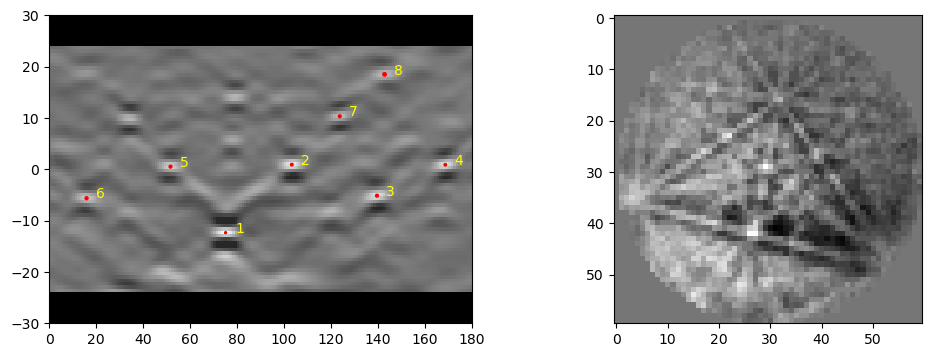

In [10]:
dat1,bnd1, indxer=ebsd_index.index_pats(filename = file,
                                     patstart = 0, npats = 1000,return_indexer_obj = True,
                                     backgroundSub = backgroundsub,
                                     nTheta = nT, nRho=nR,
                                     tSigma = tSig, rSigma = rSig,rhoMaskFrac=rhomask,nBands=nbands, \
                                     phaselist = phaselist, PC = PC, verbose = 0)
imshape = (indxer.fID.nRows, indxer.fID.nCols)
indxer.bandDetectPlan.useCPU = False
dat1,bnd1=ebsd_index.index_pats(filename = file,
                                     patstart = 0, npats = 1000, ebsd_indexer_obj=indxer, verbose=2)

The data output *dat1* here, is a complex numpy array (or array of structured data), that is `[nphases+1, npoints]`.  The data is stored for each phase used in indexing and the dat1\[-1\] layer uses the best guess on which is the most likely phase, based on the fit, and number of bands matched for each phase.  Each data entry contains the orientation expressed as a quaternion (quat) (using EDAX convention by default), Pattern Quality (pq), Confidence Metric (cm), Phase ID (phase), Fit (fit) and Number of Bands Matched (nmatch).  There are some other metrics reported, but these are mostly for debugging purposes.  

## Refine the PC guess
Here we read a set of 5x5 patterns from the center of the scan to make an optimized estimate of the pattern center.  The patterns are read into a numpy array.  Currently, only a single PC is used for each scan, but improvements for this should be coming soon.  With the default optimization method, the initial guess should be close; within ±0.1 -- 0.05, and closer is better.  

In [25]:
startcolrow = [int(imshape[1]//2)-2, int(imshape[0]//2)-2]
fID = ebsd_pattern.get_pattern_file_obj(file)
# returns patterns in an array, and the location in microns of the patterns witin the scan relative to the center of the scan
pats, xyloc = fID.read_data(returnArrayOnly=True, convertToFloat=True, patStartCount=[startcolrow, [5,5]]) 
newPC = pcopt.optimize(pats, indxer, PC0 = PC)
# actually save the PC into the indxer object.  
indxer.PC = newPC
print(newPC)

[0.47484187 0.69939625 0.64461076]


Now use that indexer object to index the whole file.  Setting `npats = -1` will index to the end of the file/array (latter on will be an example of using an array as input).  

The defaults will be to detect all the GPUs on your machine, and use them.  Scheduling is dynamic, so it does not matter if the GPUs are matched. After radon processing/peak finding, the cpus take over for performing the index voting -- thus the number of CPUs needed will depend highly on the number of phases that need to be indexed.  The number of CPUs needed also is dependent on how fast your GPUs are - on a 2019 MacPro with a Radeon 6800 GPU there are diminishing returns of including more than 32 CPUs when using the above conditions.  

The first time this executes, it will take longer as the JIT compilers need to do the initial compile. Currently, the program cache is set to the system `/tmp` directory, so after reboots, many of the programs will need to be recompiled (which happens automatically with the first run)

In [39]:

data, bnddata = ebsd_index.index_pats_distributed(filename = file,patstart = 0, npats = -1,ebsd_indexer_obj = indxer,  ncpu = 28 ) #, gpu_id = [0])

num cpu/gpu, and number of patterns per iteration: 28 2 1248 16 28
Completed:  853632  --  854854   PPS: 12441    100% 69;0 running;remaining(s)



Display the results as an IPF map.  So far the only implementation is for cubic and hex IPFs - further, more flexible representations are needed here, but are likely going to be best handled by orix or others.  

854


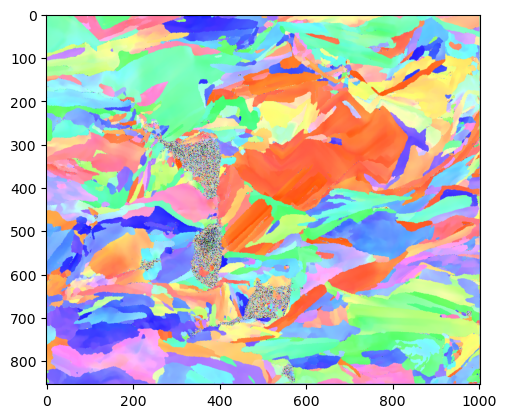

In [27]:
ipfim = IPFcolor.makeipf(data, indxer, xsize = imshape[1]); plt.imshow(ipfim)

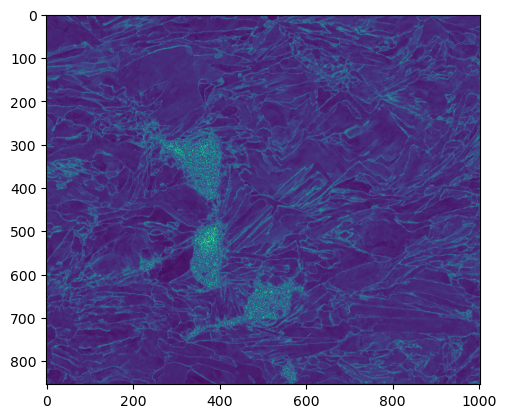

In [28]:
fit = (data[-1]['fit']).reshape(imshape[0],imshape[1]); plt.imshow(fit.clip(0, 2.0))

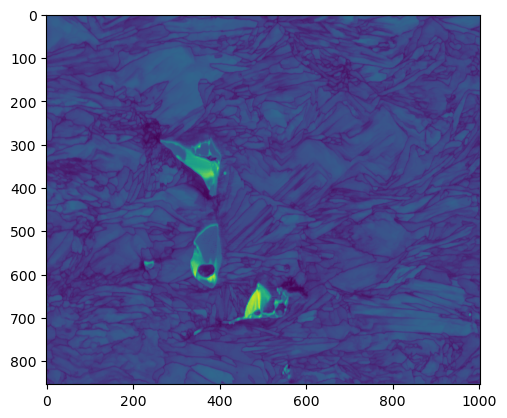

In [29]:
pq = (data[-1]['pq']).reshape(imshape[0],imshape[1]); plt.imshow(pq)

## Writing data out
Still working on this, but there are two output formats for the data arrays from PyEBSDIndex, .ang files, and .oh5 (EDAX's version of the H5EBSD data spec). 

In [42]:
ebsdfile.writeoh5(filename='MyScanData.oh5', indexer=indxer, data=data)

In [43]:
ebsdfile.writeang(filename='MyScanData.ang', indexer=indxer, data=data)

### An example of indexing an array of patterns.

It is also possible to index a numpy array of patterns.  
Here we will read part of the UP file above into an array -- note that patterns can take up a lot of RAM.  It is not normally advisable to read in an entire file of patterns if the file size is > 2GB.  

Here we read in 200cols x 300 rows = 60000 patterns starting at column 10, row 5 (0-index based) of the EBSD scan data.  What is important here is that the patterns are returned as a `(N, pH, pW)` numpy float32 array where *N* is the number of patterns, `pH` is the pattern height, and `pW` is the pattern width.  

It should be noted that patterns are expected to be arranged so that `pats[0,0,0]` corresponds to the top-left pixel as one looks at the detector towards the sample (same as the EBSD vendor standards and EMSoft version >=5.0). 

(60000, 60, 60)
float32


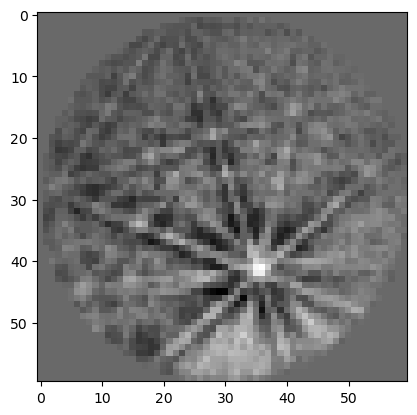

In [30]:
startcolrow = [10,5]
ncol = 200
nrow = 300

f = ebsd_pattern.get_pattern_file_obj(file)
pats, xyloc = f.read_data(returnArrayOnly=True, convertToFloat=True, patStartCount=[startcolrow, [ncol,nrow]])
# read data and return the patterns as an ndarray[npats, npatrows, npatcols], and the x,y locations within the scan (in microns), ndarray[2,npats]
print(pats.shape)
print(pats.dtype)
plt.imshow(pats[0, :, :], cmap='gray')

If the array holds a small number of patterns that can all fit on the GPU at one time, one can avoid the distributed indexing method.  It should be noted that there is built in chunking (set to fairly conservative limits) to the GPU when using *index_pats*, but no multi-processing of the band voting, so it may take a long while. This small set takes about 1.5 minutes on a 2019 Mac Pro.  

Radon Time: 1.2478941651061177
Convolution Time: 2.1195158280897886
Peak ID Time: 1.6990612583467737
Band Label Time: 1.8449941849103197
Total Band Find Time: 6.913202239898965
Band Vote Time:  75.60198848193977


<Figure size 640x480 with 0 Axes>

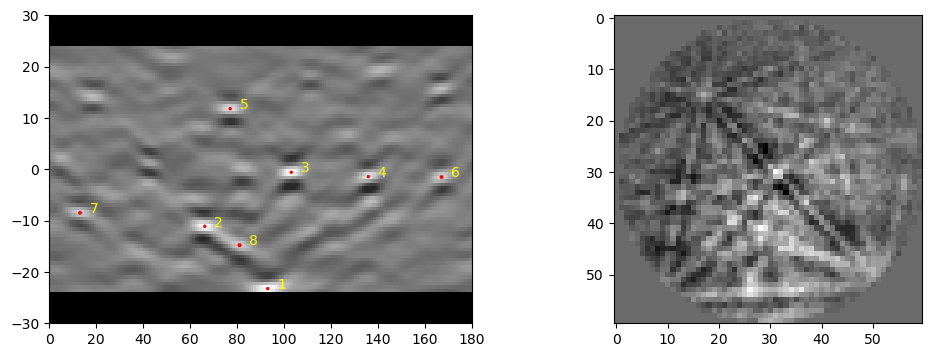

In [32]:
datasm, bnddatsm, indxer=ebsd_index.index_pats(patsin = pats,
                                     return_indexer_obj = True,
                                     backgroundSub = backgroundsub,
                                     nTheta = nT, nRho=nR,
                                     tSigma = tSig, rSigma = rSig,rhoMaskFrac=rhomask,nBands=nbands, \
                                     phaselist = phaselist, verbose = 2)


If the array is large, then the distributed indexing works on large input arrays as well.  Here a smaller number of CPU processes are used to minimize overhead of spinning up a new process.  

In [33]:
datasm, bnddatsm = ebsd_index.index_pats_distributed(patsin = pats, ebsd_indexer_obj = indxer,  ncpu = 12)

num cpu/gpu, and number of patterns per iteration: 12 2 1248 16 12
Completed:  18720  --  19968   PPS: 3716    100% 16;0 running;remaining(s)



300


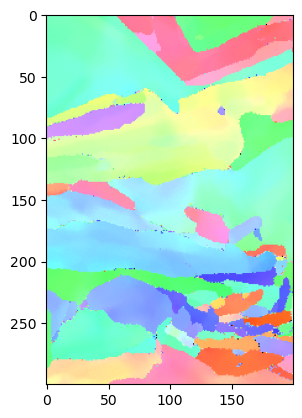

In [35]:
ipfim = IPFcolor.makeipf(datasm, indxer, xsize = 200); plt.imshow(ipfim)

And of course, one can index a single pattern as well.  In this case, *pat* can be a 2D array `(pH, pW)`:

(60, 60)


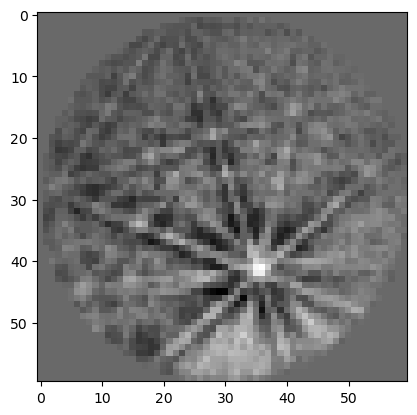

In [44]:
pat1 = pats[0,:, :]
print(pat1.shape)
plt.imshow(pat1, cmap='gray')

Radon Time: 0.007377516012638807
Convolution Time: 0.015867227921262383
Peak ID Time: 0.01943869306705892
Band Label Time: 0.009846666012890637
Total Band Find Time: 0.0525470309657976
Band Vote Time:  0.001555563067086041
('quat', 'iq', 'pq', 'cm', 'phase', 'fit', 'nmatch', 'matchattempts', 'totvotes')
[([ 0.38395016, -0.20891693,  0.28739166,  0.85225702], 0., 158503.9, 0.77072525, 0, 0.4607674, 8, [0, 1, 2, 0], 8)]


<Figure size 640x480 with 0 Axes>

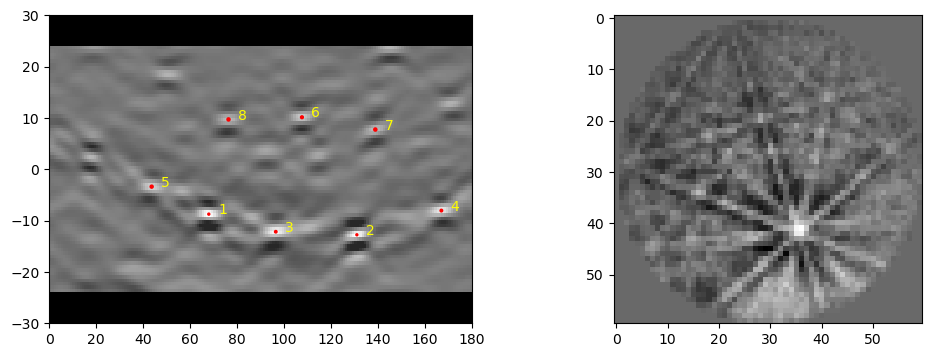

In [45]:
dat1, bnddat1 = ebsd_index.index_pats(patsin = pat1, ebsd_indexer_obj = indxer, verbose=2)
dat1 = dat1[-1]
print(dat1.dtype.names)
print(dat1)





It should be noted that this is a pretty slow indexing of one point. It may be prefered to run this all on the CPU instead:

Radon Time: 0.007330777938477695
Convolution Time: 0.019043672014959157
Peak ID Time: 0.026836892939172685
Band Label Time: 0.010746412095613778
Total Band Find Time: 0.06397646304685622
Band Vote Time:  0.0015464250463992357


<Figure size 640x480 with 0 Axes>

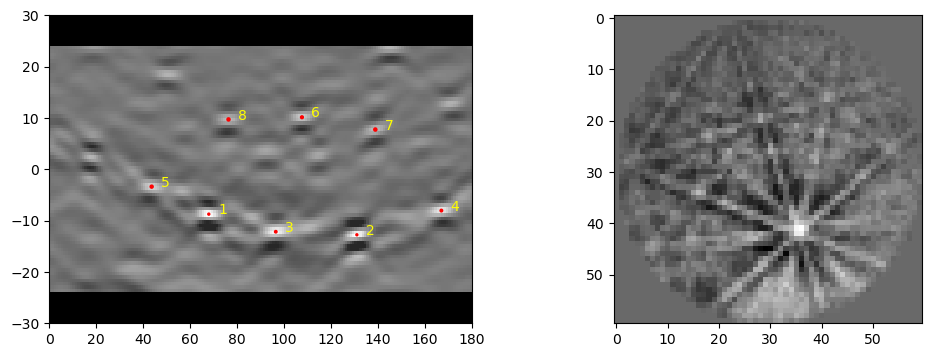

In [48]:
indxerCPU = copy.deepcopy(indxer)
indxerCPU.bandDetectPlan.useCPU = False
dat1, bnddat1 = ebsd_index.index_pats(patsin = pat1, ebsd_indexer_obj = indxerCPU, verbose=2)
dat1 = dat1 = dat1[-1]

### Loading data from an HDF5 File
There is some limited support for specific types of HDF5 files using the _"filename"_ keyword to `index_pats` or `index_pats_distributed`.  However, probably the easiest method is to just point a h5py Dataset at the `patsin` keyword (This makes the important assumption that the patterns are stored in `[npatterns, nrows, ncols]` and the first point stored is the upper left corner of the detector).  See below: 

Radon Time: 0.019871829077601433
Convolution Time: 0.05477267492096871
Peak ID Time: 0.046635095961391926
Band Label Time: 0.04914216499309987
Total Band Find Time: 0.17046290694270283
Band Vote Time:  1.3323961960850284
num cpu/gpu, and number of patterns per iteration: 28 2 1008 16 28
Completed:  852768  --  853776   PPS: 12366    100% 69;0 running;remaining(s)



<Figure size 640x480 with 0 Axes>

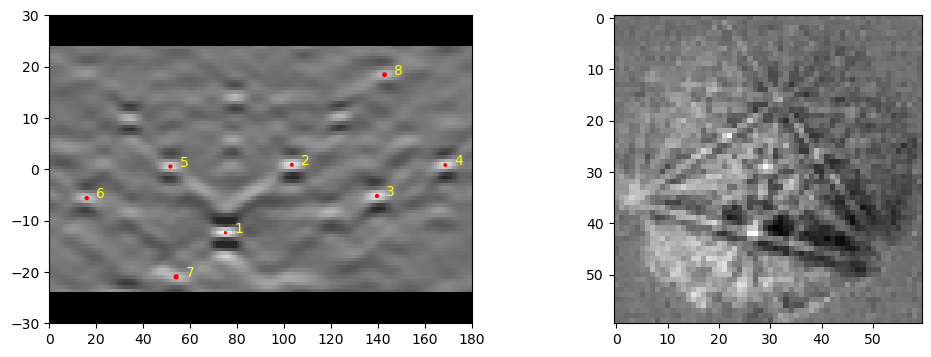

In [49]:

h5file = '/Path/to/hdf5/file.h5'
f = h5py.File(h5file, 'r') # this is an HDF5 file type used by EDAX.  
h5pats = f['/Scan 1/EBSD/Data/Pattern'] # location of the pattern array within the HDF5 file.  
# index the first 1000
h5data, h5bnddata, indxer=ebsd_index.index_pats(patsin = h5pats[0:1000,:,:],
                                     patstart = 0, npats = 1000,return_indexer_obj = True,
                                     backgroundSub = backgroundsub,
                                     nTheta = nT, nRho=nR,
                                     tSigma = tSig, rSigma = rSig,rhoMaskFrac=rhomask,nBands=nbands, \
                                     phaselist = phaselist, PC = PC, verbose = 2)
#now index them all
h5data, h5banddata = ebsd_index.index_pats_distributed(patsin = h5pats, ebsd_indexer_obj = indxer, ncpu = 28)